In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [15]:
def calc_dphi(phi1, phi2):
    dphi = phi2 - phi1
    dphi[dphi > np.pi] -= 2*np.pi
    dphi[dphi < -np.pi] += 2*np.pi
    return dphi

In [16]:
input_dir = './MPD_dataset/MPD_events'
rmaxlist = []
zminlist = []
zmaxlist = []
maxrowlist = []
minrowlist = []
particlenumlist = []
hitnumlist = []

dphi_list = []
distance_list = []
dtheta_list = []
z0_list = []

pt = []

for evtid in range(100):
    event_name = input_dir + f'/event_{evtid}_'
    print(f'Processing: {event_name:s}')

    hits = pd.read_csv(event_name + 'hits.csv')
    if not hits.empty:
        r = np.sqrt(hits.x**2 + hits.y**2)
        phi = np.arctan2(hits.y, hits.x)
        hits = hits[['hit_id', 'z', 'row_id', 'sector_id']].assign(r=r, phi=phi)
        rmaxlist.append(hits['r'].max())
        zminlist.append(hits['z'].min())
        zmaxlist.append(hits['z'].max())
        minrowlist.append(hits['row_id'].min())
        maxrowlist.append(hits['row_id'].max())
        hitnumlist.append(len(hits))

    tracks = pd.read_csv(event_name + 'tracks.csv')
    if not tracks.empty:
        particlenumlist.append(len(set(tracks['track_id'])))

    truth = pd.read_csv(event_name + 'truth.csv')

    truth = truth.merge(tracks[['track_id', 'pt', 'mother_id']], on='track_id')
    hits = hits.merge(truth, on='hit_id')

    pt.append(len(hits[(hits['pt'] < 0.1) & (hits['mother_id'] == -1)]) / (len(hits[hits['mother_id'] == -1]) + 1e-8))

    hits = hits[(hits['pt'] >= 0.1) & (hits['mother_id'] == -1)]

    hit_gropus = hits.groupby("track_id")

    for x in set(hits['track_id']):
        track_df = hit_gropus.get_group(x).assign(evtid=evtid)
        if len(track_df) > 1:
            hit_pairs = track_df.reset_index().merge(track_df.reset_index(), on='evtid', suffixes=('_1', '_2'))
            hit_pairs = hit_pairs[(hit_pairs['row_id_1'] == hit_pairs['row_id_2'] - 1) & (hit_pairs['sector_id_1'] == hit_pairs['sector_id_2'])]

            if not hit_pairs.empty:
                dphi = calc_dphi(hit_pairs.phi_1, hit_pairs.phi_2)
                dz = hit_pairs.z_2 - hit_pairs.z_1
                dr = hit_pairs.r_2 - hit_pairs.r_1
                z0 = hit_pairs.z_1 - hit_pairs.r_1 * dz / dr
                distance = np.sqrt(hit_pairs.r_1**2 + hit_pairs.r_2**2 - 2 * hit_pairs.r_1 * hit_pairs.r_2 * np.cos(dphi) + dz**2)
                theta = np.arctan(dz / dr)

                dphi_list.append(dphi.abs().max())
                distance_list.append(distance.abs().max())
                dtheta_list.append(theta.abs().max())
                z0_list.append(z0.abs().max())

Processing: ./MPD_dataset/MPD_events/event_0_
Processing: ./MPD_dataset/MPD_events/event_1_
Processing: ./MPD_dataset/MPD_events/event_2_
Processing: ./MPD_dataset/MPD_events/event_3_
Processing: ./MPD_dataset/MPD_events/event_4_
Processing: ./MPD_dataset/MPD_events/event_5_
Processing: ./MPD_dataset/MPD_events/event_6_
Processing: ./MPD_dataset/MPD_events/event_7_
Processing: ./MPD_dataset/MPD_events/event_8_
Processing: ./MPD_dataset/MPD_events/event_9_
Processing: ./MPD_dataset/MPD_events/event_10_
Processing: ./MPD_dataset/MPD_events/event_11_
Processing: ./MPD_dataset/MPD_events/event_12_
Processing: ./MPD_dataset/MPD_events/event_13_
Processing: ./MPD_dataset/MPD_events/event_14_
Processing: ./MPD_dataset/MPD_events/event_15_
Processing: ./MPD_dataset/MPD_events/event_16_
Processing: ./MPD_dataset/MPD_events/event_17_
Processing: ./MPD_dataset/MPD_events/event_18_
Processing: ./MPD_dataset/MPD_events/event_19_
Processing: ./MPD_dataset/MPD_events/event_20_
Processing: ./MPD_datas

In [17]:
np.array(dphi_list).max()

0.5139129699880387

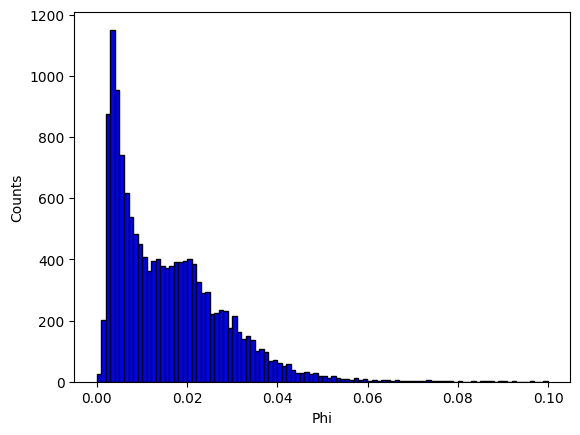

In [18]:
plt.hist(np.array(dphi_list)[np.array(dphi_list) < 0.1], bins=100, color='blue', edgecolor='black')

plt.ylabel('Counts')
plt.xlabel('Phi')

plt.show()

In [19]:
np.array(dtheta_list).max()

1.5707722918655396

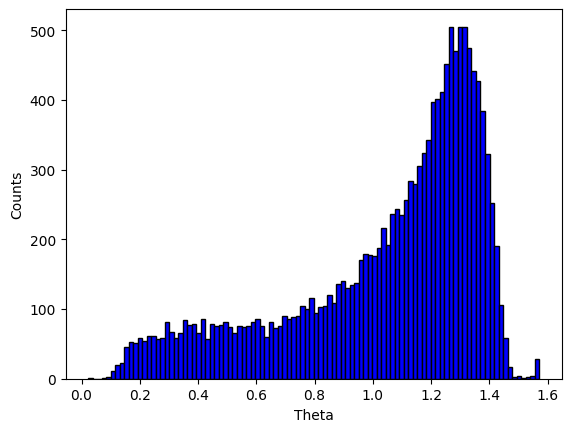

In [20]:
plt.hist(np.array(dtheta_list), bins=100, color='blue', edgecolor='black')

plt.ylabel('Counts')
plt.xlabel('Theta')

plt.show()

In [21]:
np.array(z0_list).max()

2222943.256433288

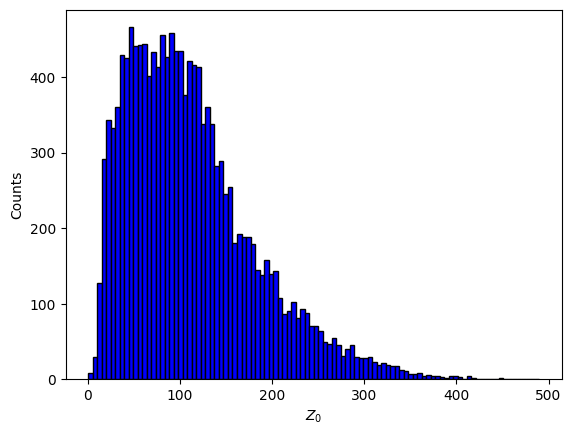

In [22]:
plt.hist(np.array(z0_list)[np.array(z0_list) < 500], bins=100, color='blue', edgecolor='black')

plt.ylabel('Counts')
plt.xlabel('$Z_{0}$')

plt.show()

In [23]:
np.array(distance_list).max()

127.26983306105969

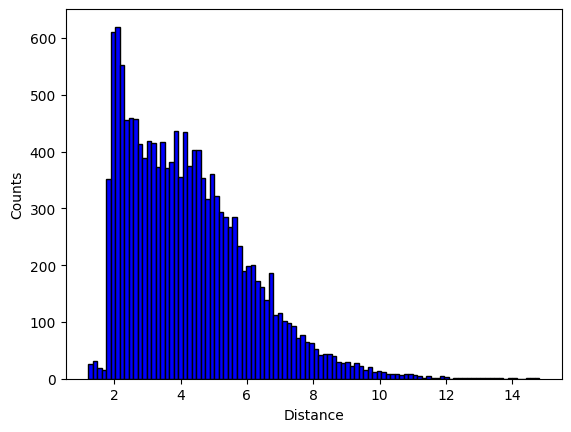

In [24]:
plt.hist(np.array(distance_list)[np.array(distance_list) < 15], bins=100, color='blue', edgecolor='black')

plt.ylabel('Counts')
plt.xlabel('Distance')

plt.show()

In [7]:
np.array(rmaxlist).max()

123.17593093299519

In [8]:
np.array(zminlist).min()

-165.853

In [9]:
np.array(zmaxlist).max()

168.646

In [10]:
np.array(minrowlist).min()

0

In [11]:
np.array(maxrowlist).max()

52

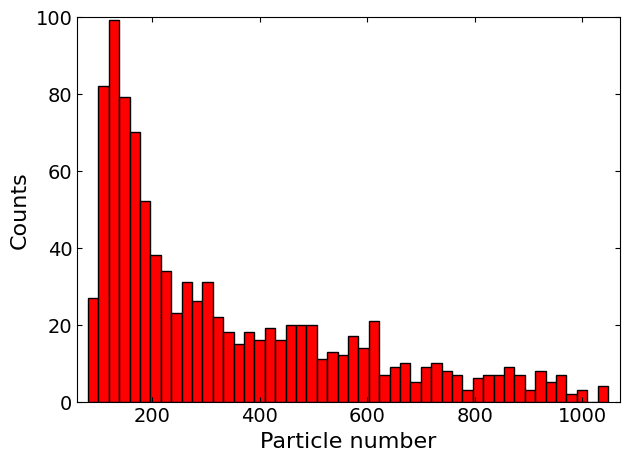

In [33]:
plt.figure(figsize=(7, 5))

plt.hist(particlenumlist, bins=50, color='red', edgecolor='black')

plt.ylabel('Counts', fontsize=16)
plt.xlabel('Particle number', fontsize=16)
plt.xlim([60, 1070])
plt.ylim([0, 100])
plt.tick_params(axis='both', 
                    which='major', 
                    labelsize=14,
                    top=True,
                    bottom=True,
                    left=True,
                    right=True,
                    direction='in')

#plt.show()
plt.savefig("Particle_number.pdf")

In [5]:
print(f'{len([x for x in particlenumlist if x > 400]) / len(particlenumlist) * 100:.2f}%')

32.60%


In [6]:
sum(particlenumlist) / len(particlenumlist)

337.768

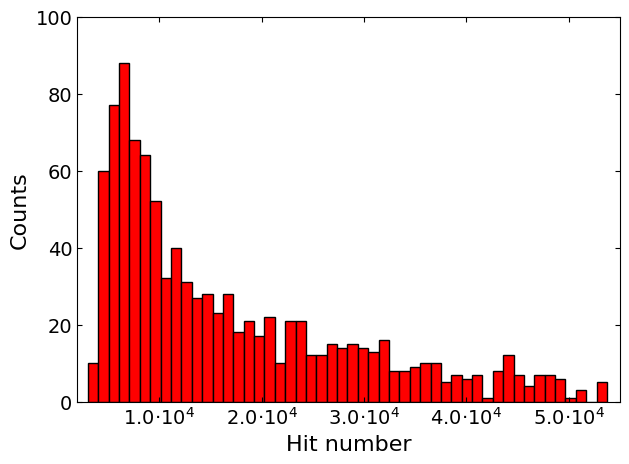

In [34]:
plt.figure(figsize=(7, 5))

plt.hist(hitnumlist, bins=50, color='red', edgecolor='black')

def format_x_ticks(x, pos):
    return f"{x / 1e4:.1f}·10$^4$"

plt.ylabel('Counts', fontsize=16)
plt.xlabel('Hit number', fontsize=16)
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_x_ticks))
plt.xlim([2000, 55000])
plt.ylim([0, 100])
plt.tick_params(axis='both', 
                    which='major', 
                    labelsize=14,
                    top=True,
                    bottom=True,
                    left=True,
                    right=True,
                    direction='in')

#plt.show()
plt.savefig("Hit_number.pdf")

In [7]:
sum(hitnumlist) / len(hitnumlist)

16989.998